In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housing_train = pd.read_csv('Datasets/HousingData_train.csv')
housing_test = pd.read_csv('Datasets/HousingData_test.csv')

housing_train.sample(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
172,0.06047,0.0,2.46,0.0,0.488,6.153,68.8,3.2797,3,193,17.8,387.11,13.15,29.6
424,8.20058,0.0,18.10,0.0,0.713,5.936,80.3,2.7792,24,666,20.2,3.50,16.94,13.5
124,0.35233,0.0,21.89,0.0,0.624,6.454,98.4,1.8498,4,437,21.2,394.08,14.59,17.1


In [3]:
print(housing_train.shape)
print(housing_test.shape)

(467, 14)
(39, 13)


In [4]:
# There is no missing value in the target variable. 
# Train and test data have missing values in the same column. 
# We will impute missing values in the pipeline using sklearn. 

housing_train.isna().sum()

CRIM       20
ZN         19
INDUS      19
CHAS       18
NOX         0
RM          0
AGE        19
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      18
MEDV        0
dtype: int64

In [5]:
housing_test.isna().sum()

CRIM       0
ZN         1
INDUS      1
CHAS       2
NOX        0
RM         0
AGE        1
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      2
dtype: int64

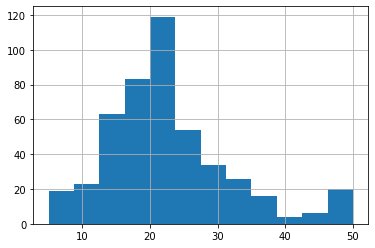

In [6]:
# The distribution of the target variable is close to being symmetric. 
# So no further transformation is done. 

housing_train['MEDV'].hist(bins=12)
plt.show()

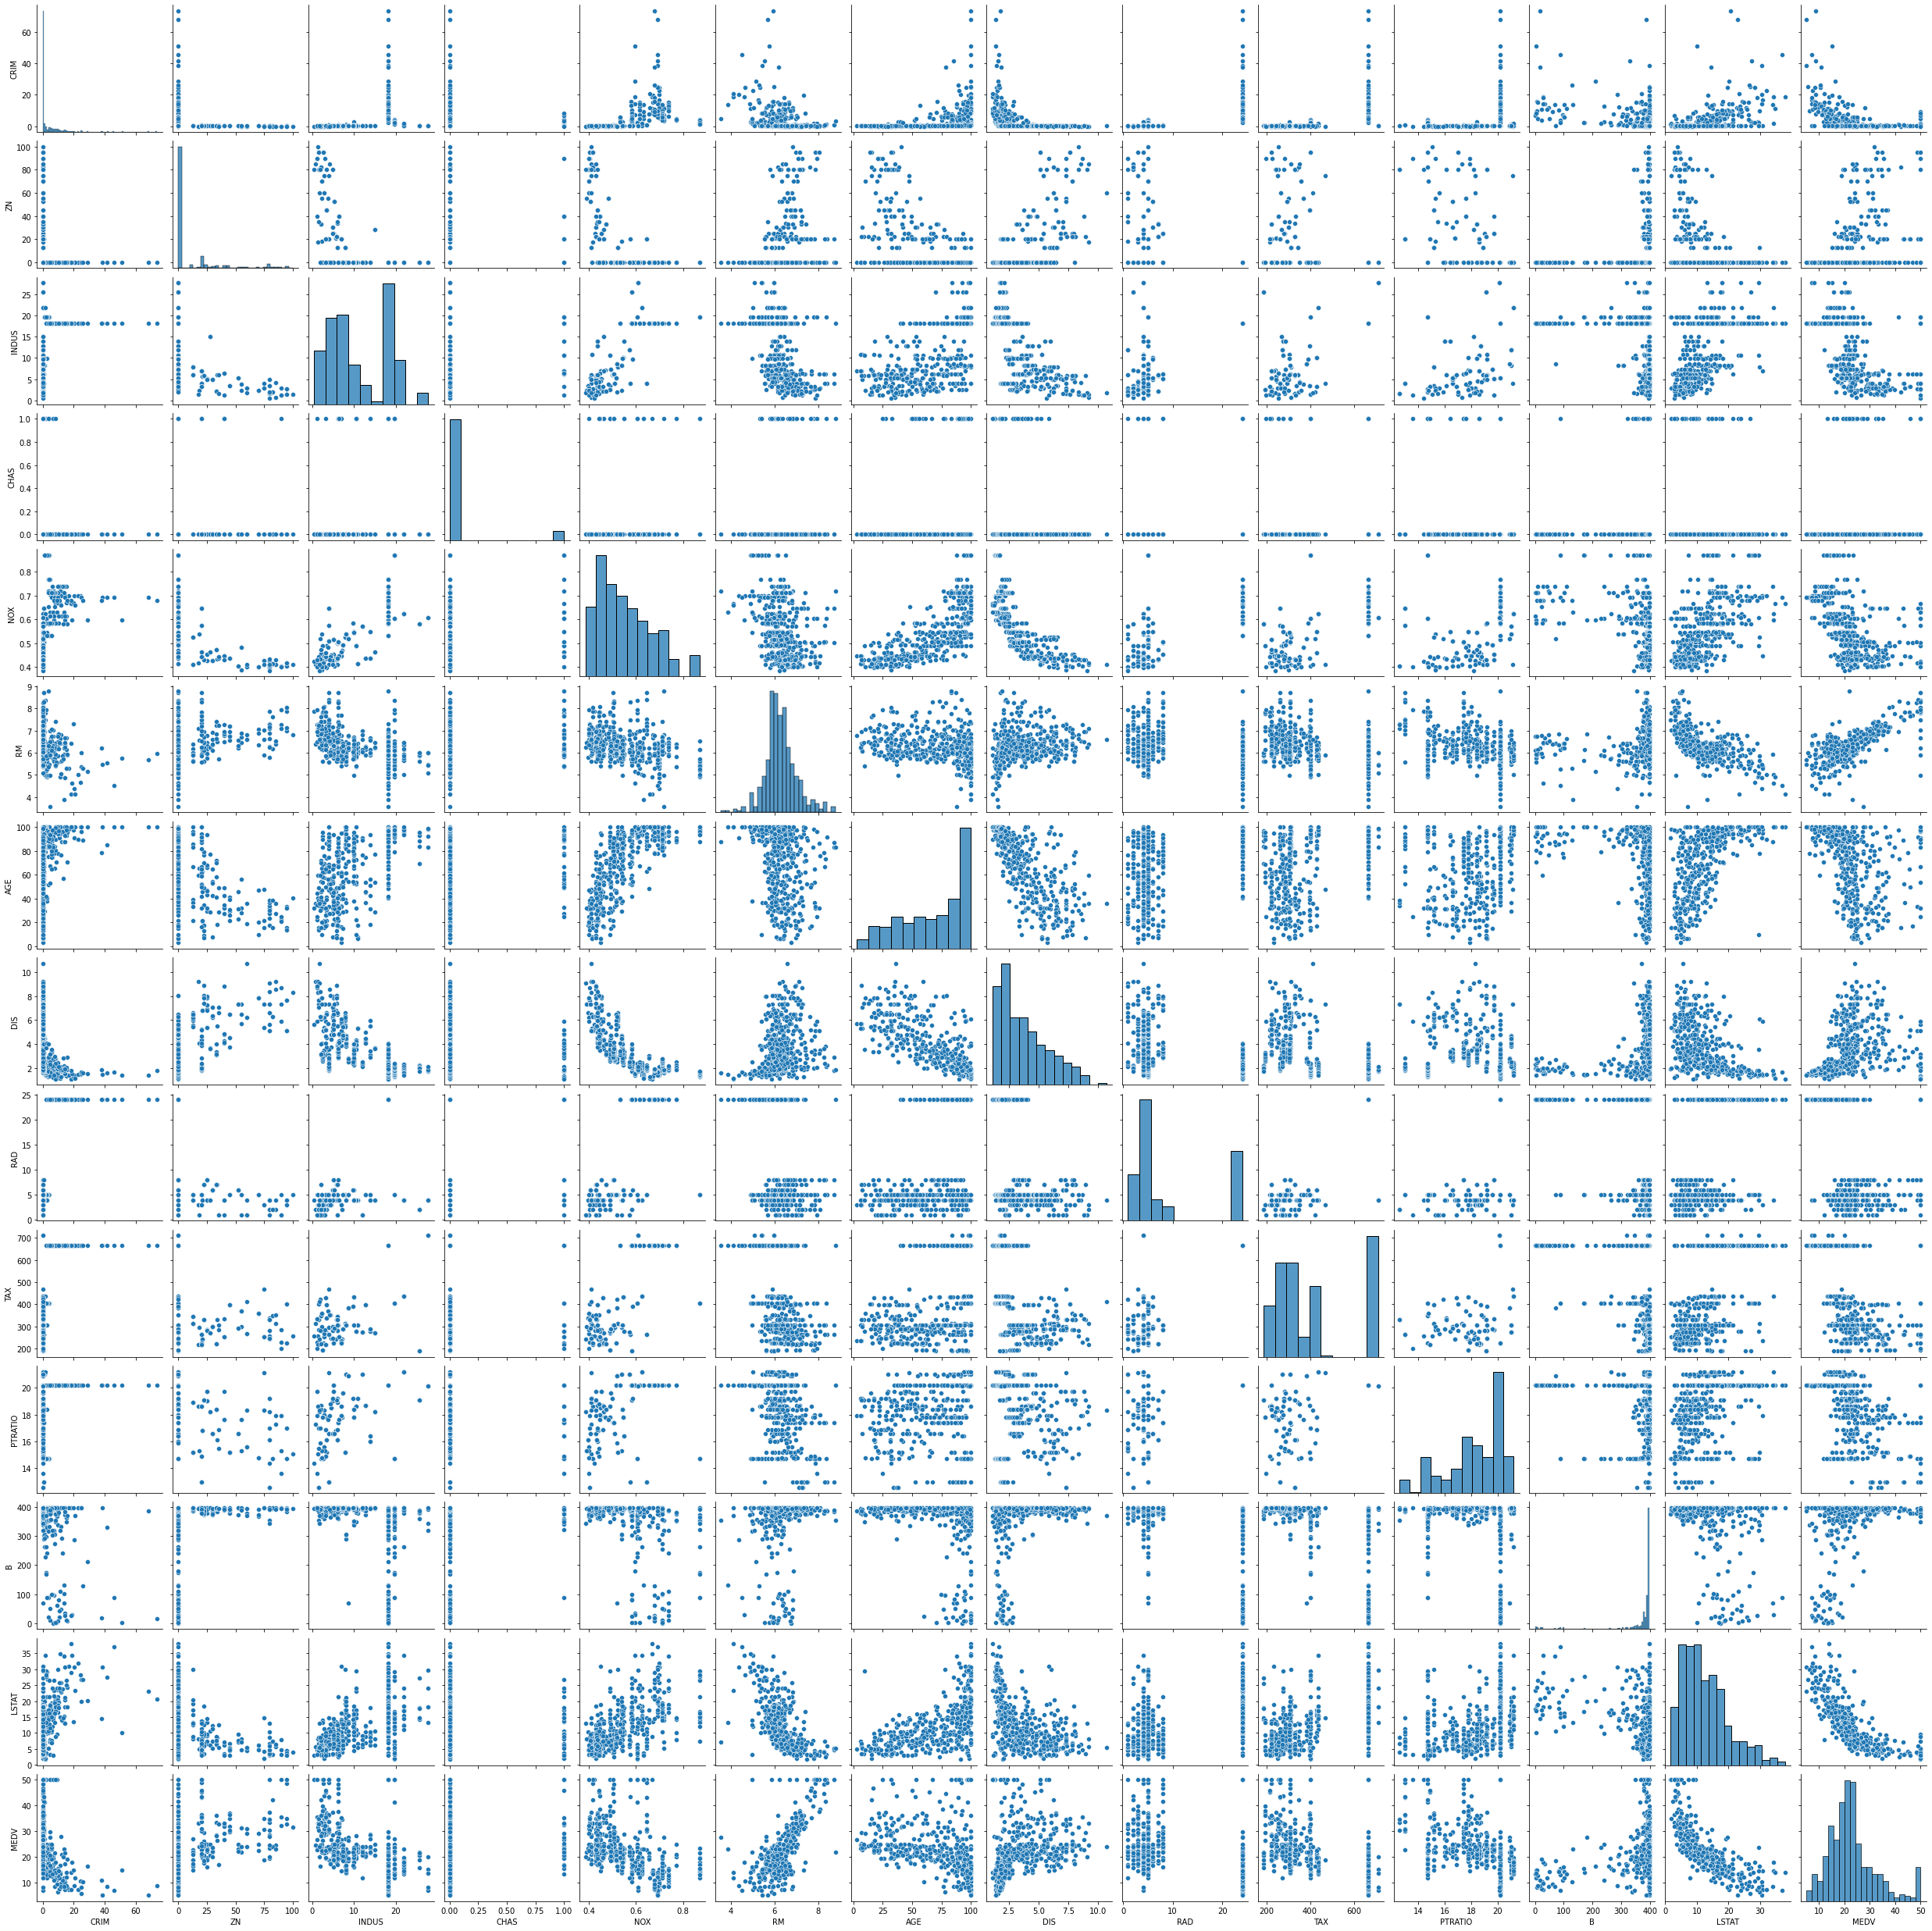

In [7]:
# There seems to be some degree of multi-collinearity going on. 
# There are a couple of leverage points and outliers. 
# I decided to leave the outliers as I am training a tree-based model. 

sns.pairplot(housing_train)
plt.show()

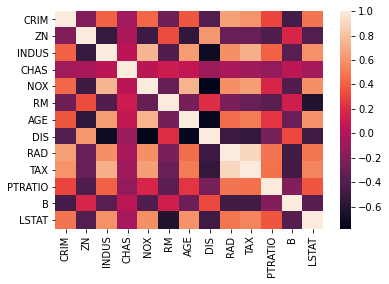

In [8]:
# Multi-collinearity is evident in this heatmap as well. 

credit = housing_train.drop('MEDV', axis=1)

sns.heatmap(credit.corr())
plt.show()

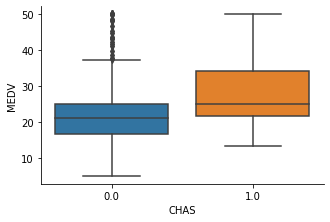

In [9]:
# CHAS is the only categorical variable in the data. 

sns.catplot(x='CHAS', y='MEDV', 
                data=housing_train, kind='box',
                height=3, aspect=1.5)
plt.show()

In [10]:
cat_feat = ['CHAS']
for feat in cat_feat:
    print(feat, '=', credit[feat].value_counts().values)

CHAS = [418  31]


# Q1: Model building 

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
X = housing_train.drop('MEDV', axis=1)
y = housing_train['MEDV']


# Although there is a separate test dataset provided, I decided to have 
# my own train data to better access the model performance. 
# The grid search method automatically does the validation set 
# split into the training data. 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=77)

cat_feat = ['CHAS']
num_feat = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', \
               'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [13]:
# I choose to do things using a pipeline. 
# Preprocess contains two steps: imputation and scaling. 
# For numerical median is used for imputation and scaled with z-score 
# For categorical mode is used for imputation and one-hot encoding is used.
# (Though one-hot encoding might not be needed for tree-based method)

num_process = make_pipeline(SimpleImputer(strategy='median'), 
                            StandardScaler())

cat_process = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                            OneHotEncoder()) 

preprocess = ColumnTransformer(transformers=
                                   [('num', num_process, num_feat), 
                                    ('cat', cat_process, cat_feat)])

In [14]:
# I choose random forest. Why?
# Because this is a simple model, easy to train, performs very well.
# Random forest is robust to outliers, leverage points, and overfitting. 
# Also it can capture non-linearity in the data. 

# Grid search is used for hyper-parameter tuning. 
# I did not do this part exhaustively. 
# I believe there is room for improvement. 

model_rf = make_pipeline(preprocess, 
                         RandomForestRegressor(n_estimators=200, 
                                               random_state=77,
                                               n_jobs=-1))

param_grid_rf = {'randomforestregressor__max_depth': [10, None], 
                'randomforestregressor__min_impurity_decrease': [0, 0.1]}

grid_rf = GridSearchCV(model_rf, cv=5, 
                       param_grid=param_grid_rf)

grid_rf.fit(X_train, y_train)
print('R2 of train data :\t', grid_rf.score(X_train, y_train))

R2 of train data :	 0.9784445214669706


In [15]:
# Roughly 77% of the variance of the testing data is explained by the model. 
# This is a decent score for this simple model. 

y_pred = grid_rf.predict(X_test)
print('R2 of test data :\t', r2_score(y_pred, y_test))
print('MSE of test data :\t', mean_squared_error(y_pred, y_test))

R2 of test data :	 0.7682952603669709
MSE of test data :	 13.26678422435895


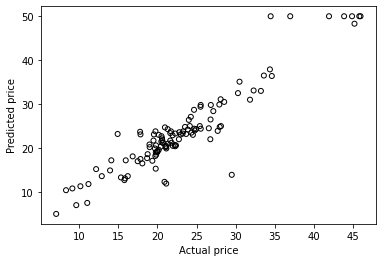

In [16]:
# Predicted vs actual price 

plt.scatter(y_pred, y_test, s = 25, facecolors = 'none', edgecolors = 'k')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.show()

In [17]:
# Here is the test dataset provided 

housing_test.sample(4)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
7,15.8744,0.0,18.10,0.0,0.671,6.545,99.1,1.5192,24,666,20.2,396.90,21.08
10,0.1712,0.0,8.56,0.0,0.520,5.836,91.9,2.2110,5,384,20.9,395.67,18.66
27,0.2896,0.0,9.69,0.0,0.585,5.390,72.9,2.7986,6,391,19.2,396.90,21.14
8,0.1396,0.0,8.56,0.0,0.520,6.167,90.0,2.4210,5,384,20.9,392.69,12.33


In [18]:
# Here are the predictions made on the test dataset 

grid_rf.predict(housing_test)

array([11.0665, 20.266 , 20.7975, 14.9455, 10.6175, 10.905 , 16.987 ,
       10.9645, 19.66  , 18.7725, 17.3545, 19.595 , 19.9315, 40.974 ,
       22.7145, 20.792 , 40.195 , 21.701 , 30.0075, 21.05  , 22.4325,
       13.725 , 20.434 , 20.723 , 19.5735, 20.1925, 17.9185, 17.4675,
       19.4715, 20.5075, 17.975 , 22.895 , 15.5055, 19.559 , 15.8755,
       15.7795, 16.1095, 27.485 , 25.866 ])

# Q2: API to predict the result 

In [ ]:
# This part is very preliminary and can be improved in many ways.

# I assumed a setup where the user is asked to input the values of the features 
# and he/she knows the predicted price as output. 

In [19]:
def know_your_house_price():

    '''This function asks the information about 
    the house and predicts the price.'''
    
    vals = []

    for col in housing_test.columns:
        if housing_test[col].dtypes=='float64':
            val = float(input('What is {}? '.format(col)))
            vals.append(val)

        elif housing_test[col].dtypes=='int64':
            val = int(input('What is {}? '.format(col)))
            vals.append(val)

    sample_test = pd.DataFrame({col:[val] for col, val in \
                                zip(housing_test.columns, vals)})

    price_predict = int(1000 * grid_rf.predict(sample_test)[0])

    print('\nYour house worth {} dollars.'.format(price_predict))

In [20]:
# Let's work with a known data point and input the same values 
# and see if we get the expected output. 

housing_train.loc[0:0]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


In [23]:
# Predicted price is close to 24 (in thousand)

know_your_house_price()

What is CRIM? 0.00632
What is ZN? 18
What is INDUS? 2.31
What is CHAS? 0
What is NOX? 0.538
What is RM? 6.575
What is AGE? 65.2
What is DIS? 4.09
What is RAD? 1
What is TAX? 296
What is PTRATIO? 15.3
What is B? 396.9
What is LSTAT? 4.98

Your house worth 24767 dollars.


In [ ]:
# Thanks for reading!